# **Libraries & Constants**

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
# from keras.layers.merge import concatenate
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from scipy import sparse
import os
import string
from google.colab import drive
import json
import pickle

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
import spacy
import nltk
nltk.download('stopwords')
import re
# from transformers import AutoTokenizer,BertTokenizer,TFBertModel

import copy

# **Load Dataset and declare paths**

In [ ]:
drive.mount('/content/drive')
basePath = '/content/drive/MyDrive/AI Projects/Sentiment-Analysis/'
dataPath = basePath + 'amazon_reviews_us_Watches_v1_00.csv'

# **Preprocessing**

## **Tokenization, Stemming, Removing Stop words and Punctuation**

In [102]:
dataset = pd.read_csv(dataPath)

<ipython-input-102-5118f10c515a>:1: DtypeWarning: Columns (17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(dataPath)


In [103]:
useless_features = ['review_date', 'verified_purchase'] + list(dataset.columns[8:11]) + list(dataset.columns[0:7]) + list(dataset.columns[-7:])
print(useless_features)

dataset.drop(columns=useless_features, inplace=True)
# delete rows with nan elements
dataset = dataset.dropna()

['review_date', 'verified_purchase', 'helpful_votes', 'total_votes', 'vine', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']


In [104]:
review_headline = np.array(dataset['review_headline'])
review_body = np.array(dataset['review_body'])
star_rating = np.array(dataset['star_rating'])
rev_class = np.empty_like(star_rating)

for i  in range(len(rev_class)):
  if star_rating[i] >= 4:
    rev_class[i] = 1  # class1 : Pos Class
  elif star_rating[i] <= 2:
    rev_class[i] = 2  # class2 : Neg class
  elif star_rating[i] == 3:
    rev_class[i] = 3  # class3 : Neutral class

dataset['rev_class'] = rev_class

dataset.head()

,star_rating,review_headline,review_body,rev_class
0,5,Five Stars,Absolutely love this watch! Get compliments al...,1
1,5,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,1
2,2,Two Stars,Scratches,2
3,5,Five Stars,"It works well on me. However, I found cheaper ...",1
4,4,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,1


In [105]:
rev_class.shape

(960082,)

In [106]:
pos_indices = np.where(rev_class == 1)[0]
neg_indices = np.where(rev_class == 2)[0]
neut_indice = np.where(rev_class == 3)[0]

np.random.seed(5)
pos_indices = np.random.choice(pos_indices, size=3300, replace=False)
neg_indices = np.random.choice(neg_indices, size=3300, replace=False)
neut_indices = np.random.choice(neut_indice, size=3400, replace=False)

sample_indices = np.concatenate([pos_indices, neg_indices, neut_indices], axis=0)
sample_indices

array([704698, 659317,  69078, ..., 242400, 285939, 890903])

In [107]:
review_headline_sample = np.take(review_headline, sample_indices)
review_body_sample = np.take(review_body, sample_indices)
rev_class_sample = np.take(rev_class, sample_indices)

np.save(basePath + 'review_class.npy', rev_class_sample)

rev_class_sample.shape, review_body_sample.shape, review_headline_sample.shape

((10000,), (10000,), (10000,))

In [108]:
def w_tokenizer(text):
  tokenizer = WhitespaceTokenizer()
  tokenized_list = tokenizer.tokenize(text)
  return tokenized_list

def stemmer_porter(text_list):
  porter = PorterStemmer()
  return_list = []
  for i in range(len(text_list)):
      return_list.append(porter.stem(text_list[i]))
  return(return_list)


def remove_stopwords(text_list):
  NLTK_stopwords = nltk.corpus.stopwords.words('english')
  return_list = []
  for i in range(len(text_list)):
      if text_list[i] not in NLTK_stopwords:
          return_list.append(text_list[i])
  return return_list

def remove_punc(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        return_list = []
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            temp_text = re.sub('[0-9][0-9]+', '', temp_text.lower())
            temp_text = re.sub('\bbr\b', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

def preprocess_sentence(sentence):
  return remove_stopwords(stemmer_porter(remove_punc(w_tokenizer(sentence))))

In [109]:
with tf.device('/GPU:0'):
  preprocessed_review_headline = [preprocess_sentence(x) for x in review_headline_sample]
  preprocessed_review_body = [preprocess_sentence(x) for x in review_body_sample]

preprocessed_review_headline_length = len(preprocessed_review_headline)
preprocessed_review_body_length = len(preprocessed_review_body)

In [110]:
print(review_headline[484344])
print(preprocess_sentence(review_headline[484344]))

送人用的，希望会喜欢。To send people, hope you like
['送人用的希望会喜欢to', 'send', 'peopl', 'hope', 'like']


In [111]:
# Tfidf Vectorizer (convert tokens to vector)
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word', stop_words='english', lowercase=False, max_features=1000) #, token_pattern='(\d{0,2}[a-zA-Z]+\d{0,2}[a-zA-Z]*$)'
review_vector = vectorizer.fit_transform(preprocessed_review_headline + preprocessed_review_body)

sparse.save_npz(basePath + "review_vector_csr_matrix.npz", review_vector)

review_headline_vector = review_vector.toarray()[:preprocessed_review_headline_length]
review_body_vector = review_vector.toarray()[preprocessed_review_headline_length:]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [112]:
tfidf_features = vectorizer.get_feature_names_out()
print('number of features in tfidf: ', len(tfidf_features))

number of features in tfidf:  1000


In [113]:
print('review_headline_vector shape: ', review_headline_vector.shape)
print('review_body_vector shape: ', review_body_vector.shape)

review_headline_vector shape:  (10000, 1000)
review_body_vector shape:  (10000, 1000)


In [114]:
preprocessed_review_headline[:5]

[['doe', 'job'],
 ['decent', 'watch', 'hard', 'adjust', 'band'],
 ['five', 'star'],
 ['huge', 'hit'],
 ['fantast', 'watch']]

In [115]:
review_headline_vector[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Load Preprocessed Dataset**

In [122]:
review_vector = sparse.load_npz(basePath + "review_vector_csr_matrix.npz")

preprocessed_review_headline_length = 10000
review_headline_vector = review_vector.toarray()[:preprocessed_review_headline_length]
review_body_vector = review_vector.toarray()[preprocessed_review_headline_length:]
review_class = np.load(basePath + 'review_class.npy')

review_headline_vector.shape, review_body_vector.shape, review_class.shape

((10000, 1000), (10000, 1000), (10000,))

**Splitting Dataset**

In [138]:
headline_train, headline_test, body_train, body_test, y_train, y_test = train_test_split(review_headline_vector, review_body_vector, review_class, test_size=0.40, random_state=75)
headline_dev, headline_test, body_dev, body_test, y_dev, y_test = train_test_split(headline_test, body_test, y_test, test_size=0.50, random_state=75)

print('train shape: ', headline_train.shape, body_train.shape, y_train.shape)
print('dev shape: ', headline_dev.shape, body_dev.shape, y_dev.shape)
print('test shape: ', headline_test.shape, body_test.shape, y_test.shape)

train shape:  (6000, 1000) (6000, 1000) (6000,)
dev shape:  (2000, 1000) (2000, 1000) (2000,)
test shape:  (2000, 1000) (2000, 1000) (2000,)


# **Models**

## **Naive Bayez**

In [139]:
from sklearn.naive_bayes import GaussianNB

X_train = body_train
X_test = body_test

# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

# Predict Output
predicted = model.predict([X_test[6]])

print("Actual Value:", y_test[6])
print("Predicted Value:", predicted[0])

Actual Value: 1
Predicted Value: 1


In [140]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.562
F1 Score: 0.5735942365972914


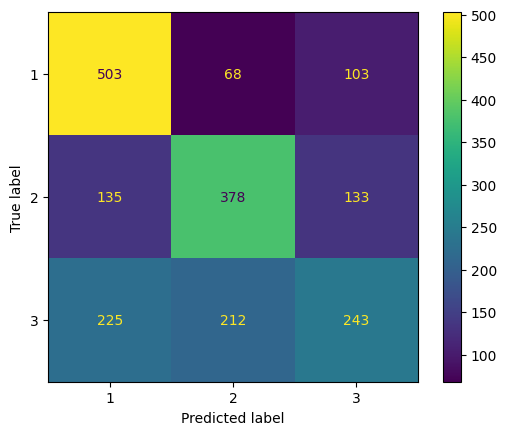

In [141]:
labels = [1,2,3]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## **Neural Network**

In [165]:
X_train = [headline_train, body_train]
X_dev = [headline_dev, body_dev]
X_test = [headline_test, body_test]


y_trainn = to_categorical(y_train)[:, 1:4]
y_devv = to_categorical(y_dev)[:, 1:4]
y_testt = to_categorical(y_test)[:, 1:4]

validation_data = (X_dev[1], y_devv)
y_trainn.shape

(6000, 3)

In [172]:
# Funcionl Model
input1 = Input(shape=np.array(X_train[0]).shape[1:])
input2 = Input(shape=np.array(X_train[1]).shape[1:])

# x1 = LSTM(128, return_sequences=True)(input1)
# x1 = LSTM(128)(input1)

# x2 = LSTM(128, return_sequences=True)(input2)
# x2 = LSTM(128)(input2)

# c = Concatenate(axis=0)([input1, input1])

d = Dense(256, activation='relu')(input1)
# d = Dense(256, activation='relu')(d)
d = Dense(64, activation='relu')(d)

output = Dense(3, activation="sigmoid")(d)

# Compile the Model
model = Model(inputs=input1, outputs=output)
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])

In [173]:
# train the model
filepath = 'NN_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
history = model.fit(X_train[1], y_trainn, validation_data=validation_data, epochs=20, batch_size=250, verbose=2, callbacks=[checkpoint]).history
model = load_model(filepath)

Epoch 1/20
24/24 - 2s - loss: 0.6471 - accuracy: 0.4735 - val_loss: 0.6167 - val_accuracy: 0.6205 - 2s/epoch - 76ms/step
Epoch 2/20
24/24 - 0s - loss: 0.5693 - accuracy: 0.6762 - val_loss: 0.5264 - val_accuracy: 0.6350 - 331ms/epoch - 14ms/step
Epoch 3/20
24/24 - 0s - loss: 0.4598 - accuracy: 0.6898 - val_loss: 0.4647 - val_accuracy: 0.6520 - 374ms/epoch - 16ms/step
Epoch 4/20
24/24 - 0s - loss: 0.3980 - accuracy: 0.7235 - val_loss: 0.4580 - val_accuracy: 0.6535 - 336ms/epoch - 14ms/step
Epoch 5/20
24/24 - 0s - loss: 0.3650 - accuracy: 0.7530 - val_loss: 0.4598 - val_accuracy: 0.6530 - 299ms/epoch - 12ms/step
Epoch 6/20
24/24 - 0s - loss: 0.3388 - accuracy: 0.7758 - val_loss: 0.4672 - val_accuracy: 0.6525 - 319ms/epoch - 13ms/step
Epoch 7/20
24/24 - 0s - loss: 0.3186 - accuracy: 0.7925 - val_loss: 0.4813 - val_accuracy: 0.6475 - 354ms/epoch - 15ms/step
Epoch 8/20
24/24 - 0s - loss: 0.2968 - accuracy: 0.8123 - val_loss: 0.4951 - val_accuracy: 0.6460 - 328ms/epoch - 14ms/step
Epoch 9/20


# **Helper**

In [ ]:
def deleteSomeIndicesFromList(a, indices):
  a = a.copy()
  for index in sorted(indices, reverse=True):
    a.pop(index)
  return a

indices = [i for i, x in enumerate(review_body_encoded) if len(x)==0]
indices = indices + [i for i, x in enumerate(review_headline_encoded) if len(x)==0]
indices = np.unique(indices)

print('index of samples which their body or headline are empty: ', indices)

review_body_dropped = deleteSomeIndicesFromList(review_body_encoded, indices)
review_headline_dropped = deleteSomeIndicesFromList(review_headline_encoded, indices)
rev_class_dropped = deleteSomeIndicesFromList(rev_class, indices)

len(review_body_dropped), len(review_headline_dropped), len(rev_class_dropped)

index of samples which their body or headline are empty:  [  1514   1632   1830 ... 952604 955484 956398]


(958554, 958554, 958554)